In [2]:
from lbmpy.session import *
from lbmpy.parameterization import Scaling

In [3]:
cavity_length = 1
lid_velocity = 1
Re = 5000
kinematic_viscosity = cavity_length*lid_velocity/Re
cell_number = 128
sc = Scaling(
    physical_length=cavity_length,
    physical_velocity=lid_velocity,
    kinematic_viscosity=kinematic_viscosity,
    cells_per_length=cell_number/cavity_length
)
lattice_velicity = 0.1
scaling_result = sc.fixed_lattice_velocity_scaling(lattice_velocity=lattice_velicity)
print(scaling_result)
relaxation_rate = scaling_result.relaxation_rate
dt = scaling_result.dt

FixedLatticeVelocityScalingResult(relaxation_rate=1.9697447210841474, dt=0.00078125)


In [4]:
stencil = LBStencil(Stencil.D2Q9)
domain_size = (cell_number, cell_number)
dim = len(domain_size)

In [5]:
dh = ps.create_data_handling(domain_size=domain_size, periodicity=(False, False))
src = dh.add_array('src', values_per_cell=len(stencil), alignment=True)
dh.fill('src', 0.0, ghost_layers=True)
dst = dh.add_array('dst', values_per_cell=len(stencil), alignment=True)
dh.fill('src', 0.0, ghost_layers=True)

velField = dh.add_array('velField', values_per_cell=dh.dim, alignment=True)
dh.fill('velField', 0.0, ghost_layers=True)

In [6]:
lbm_config = LBMConfig(
    stencil=Stencil.D2Q9,
    method=Method.CUMULANT,
    relaxation_rate=relaxation_rate,
    compressible=True,
    output={'velocity': velField},
    kernel_type='stream_pull_collide'
)
method = create_lb_method(lbm_config=lbm_config)
method

In [7]:
from lbmpy.macroscopic_value_kernels import pdf_initialization_assignments
init = pdf_initialization_assignments(
    method,
    1.0,
    (0.0, 0.0),
    src.center_vector
)
ast_init = ps.create_kernel(init, target=dh.default_target)
kernel_init = ast_init.compile()

dh.run_kernel(kernel_init)

In [8]:
lbm_optimisation = LBMOptimisation(
    symbolic_field=src,
    symbolic_temporary_field=dst
)
update = create_lb_update_rule(
    lb_method=method,
    lbm_config=lbm_config,
    lbm_optimisation=lbm_optimisation
)
ast_kernel = ps.create_kernel(
    update,
    target=dh.default_target,
    cpu_openmp=True
)
kernel = ast_kernel.compile()

/home/q/.local/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/q/.local/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


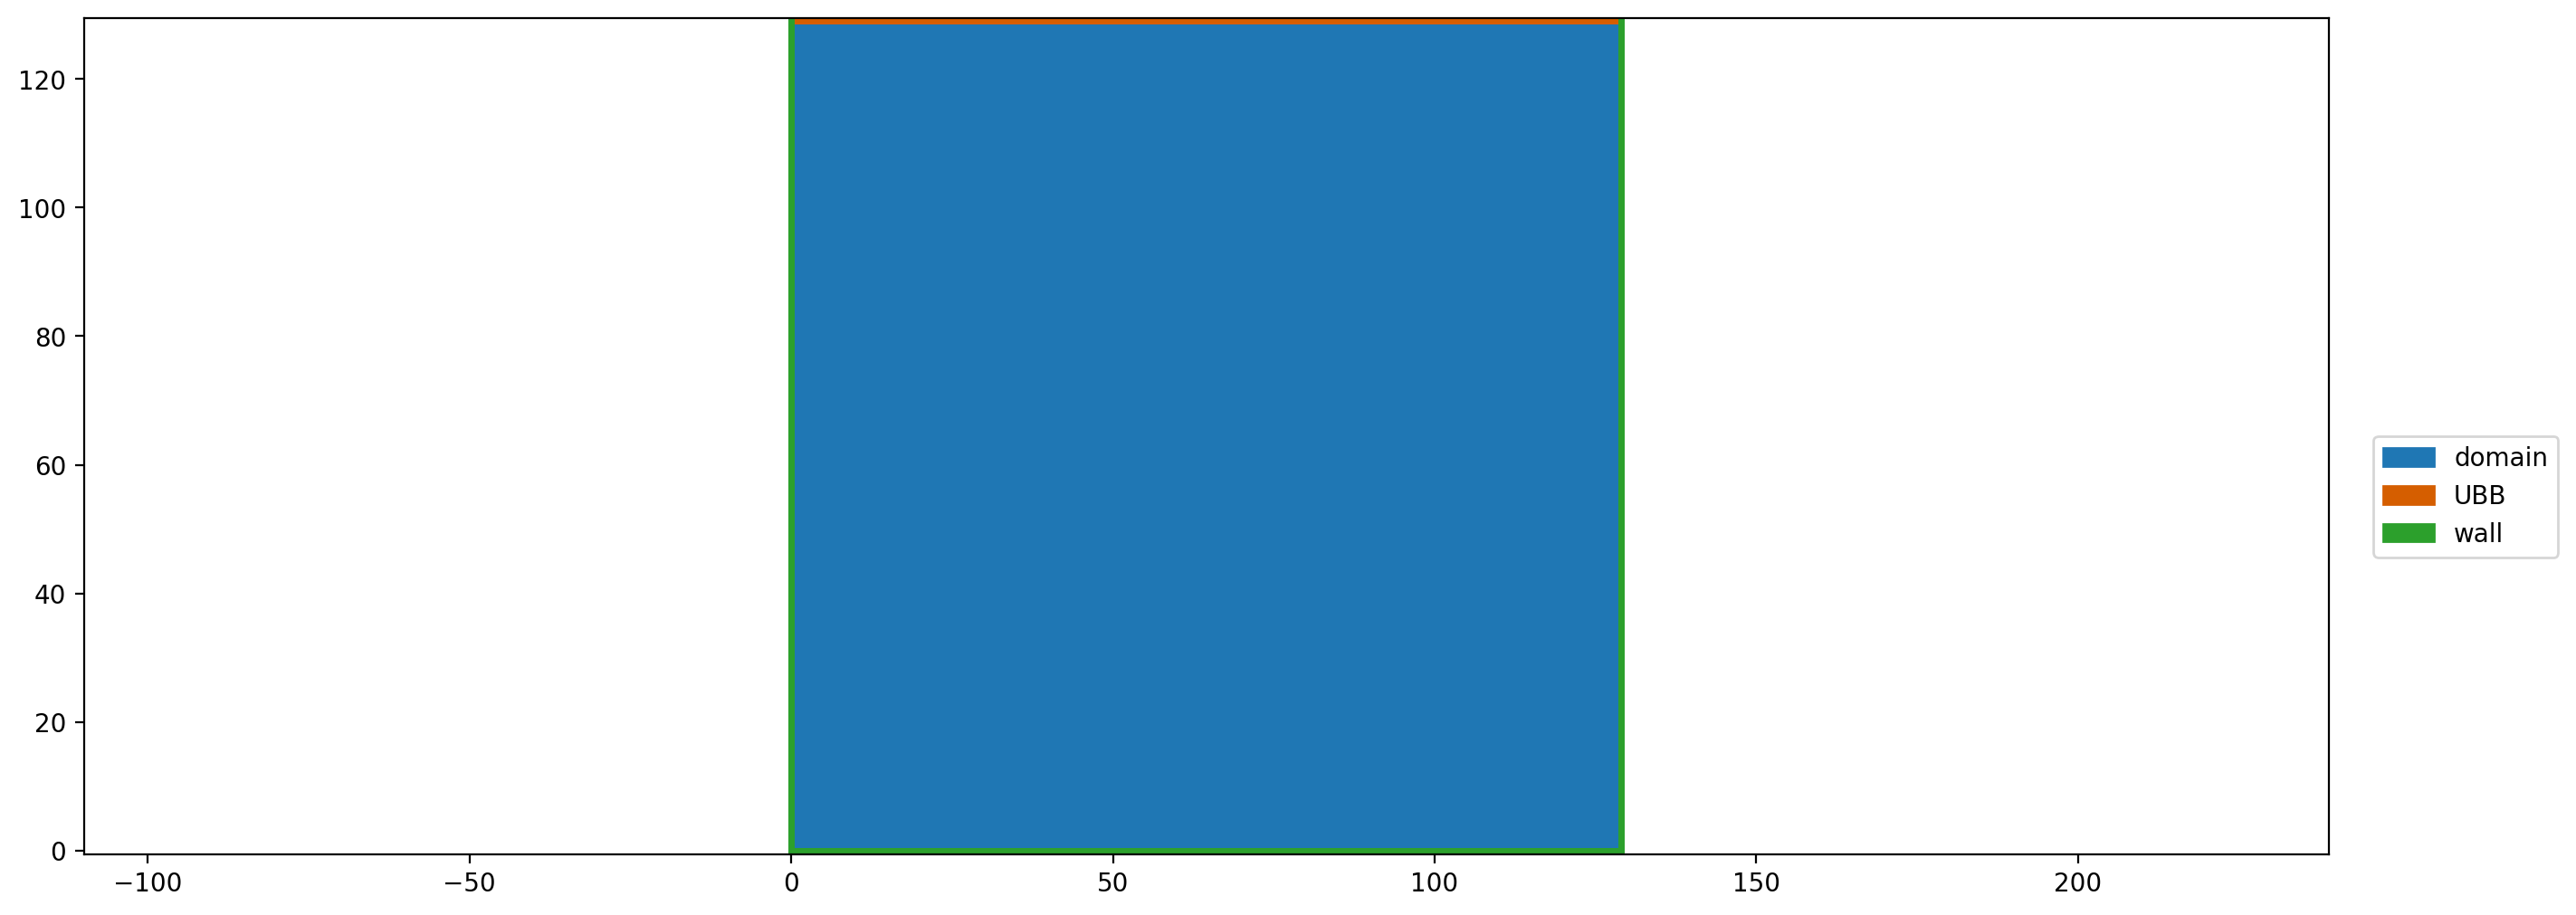

In [9]:
bh = LatticeBoltzmannBoundaryHandling(method, dh, 'src', name='bh')
lid_ubb = UBB(velocity=(lattice_velicity, 0))
wall = NoSlip('wall')
bh.set_boundary(lid_ubb, slice_from_direction('N', dim))
for direction in ('W', 'E', 'S'):
    bh.set_boundary(wall, slice_from_direction(direction, dim))

plt.figure(dpi=200)
plt.boundary_handling(bh)

In [10]:
def time_loop(nstep):
    for i in range(nstep):
        bh()
        dh.run_kernel(kernel)
        dh.swap('src', 'dst')

In [11]:
time_loop(50000)

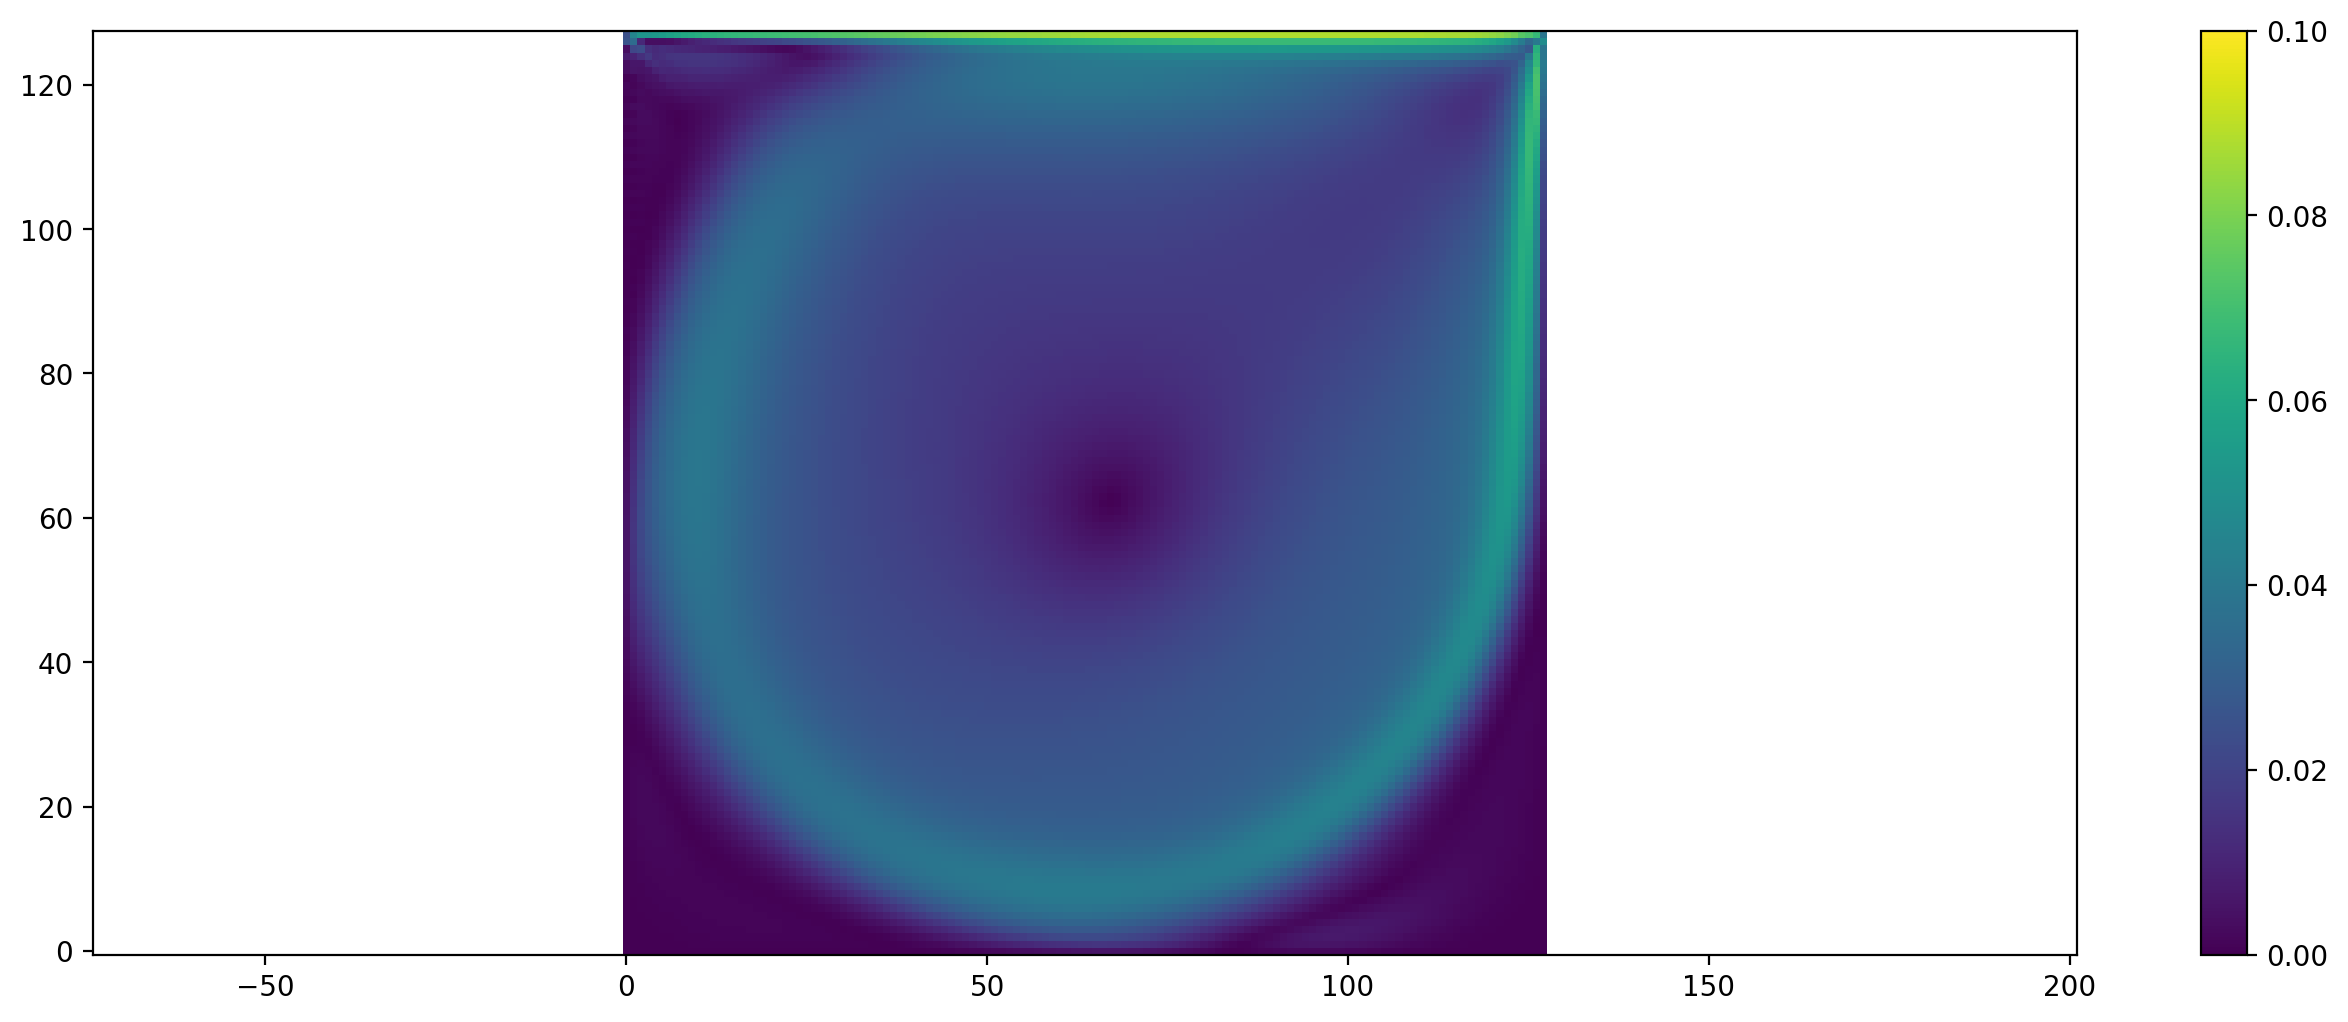

In [15]:
plt.figure(dpi=200)
plt.vector_field_magnitude(dh.gather_array('velField'), vmin=0, vmax=lattice_velicity)
plt.colorbar()